##  Import libraries ##

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from sklearn.cluster import KMeans

## Open the file

In [43]:
file_path = 'Trips_2018.csv'

if not os.path.exists('plots'):
    os.makedirs('plots')

with open(file_path, 'r') as f:
    df = pd.read_csv(f)

## Get the keys

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548339 entries, 0 to 17548338
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Unnamed: 0               int64  
 1   tripduration             int64  
 2   starttime                object 
 3   stoptime                 object 
 4   start_station_id         float64
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           float64
 8   end_station_latitude     float64
 9   end_station_longitude    float64
 10  bikeid                   int64  
 11  usertype                 object 
 12  birth_year               int64  
 13  gender                   int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 1.8+ GB


## See how many the missing values are (they are 0.01% of the dataset, we can drop them)

In [41]:
# # Missing values
# missing_values = df.isnull().sum()
# print(missing_values)

# # Drop rows with the missing IDs
# df = df[pd.to_numeric(df['start_station_id'], errors='coerce').notnull()]
# df = df[pd.to_numeric(df['end_station_id'], errors='coerce').notnull()]
# df

<class 'pandas.core.frame.DataFrame'>
Index: 17545842 entries, 970 to 2459
Data columns (total 13 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   Unnamed: 0               int64         
 1   starttime                datetime64[ns]
 2   stoptime                 datetime64[ns]
 3   start_station_id         float64       
 4   start_station_latitude   float64       
 5   start_station_longitude  float64       
 6   end_station_id           float64       
 7   end_station_latitude     float64       
 8   end_station_longitude    float64       
 9   bikeid                   int64         
 10  usertype                 object        
 11  birth_year               int64         
 12  gender                   int64         
dtypes: datetime64[ns](2), float64(6), int64(4), object(1)
memory usage: 1.8+ GB


/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/mike/miniconda

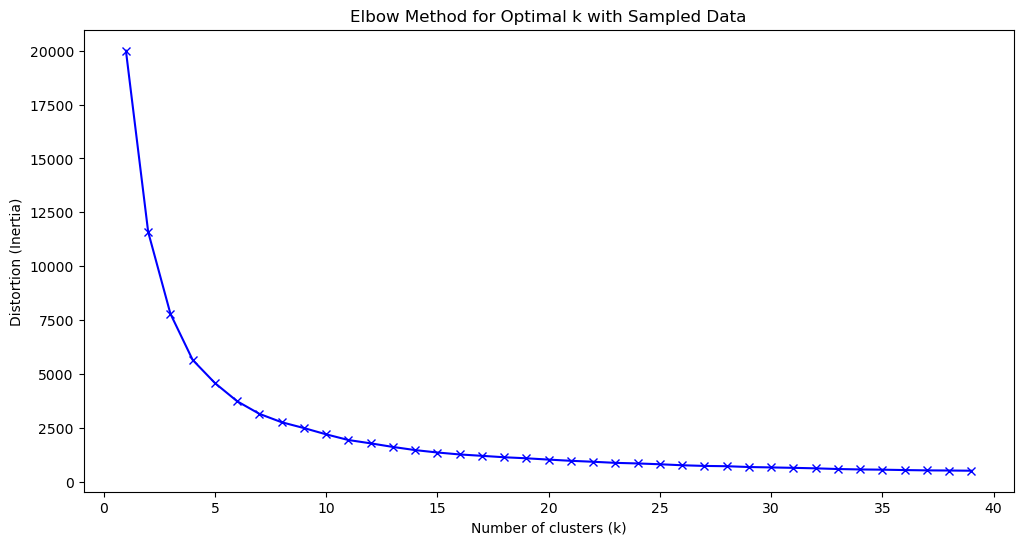

In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#Finding the optimal number of clusters with elbow method

#this method is time consuming so instead of using the entire dataset to find the optimal number of clusters,I am working with a random sample.

sample_size = 10000 
df_sample = df.sample(n=sample_size, random_state=42)

# Extract coordinates from the sample
coordinates_sample = df_sample[['start_station_latitude', 'start_station_longitude']]

#Standardize the coordinates
scaler = StandardScaler()
coordinates_standardized = scaler.fit_transform(coordinates_sample)
# coordinates_sample = coordinates_standardized

#Elbow method
distortions = []
K = range(1, 40)  
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coordinates_standardized)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(12, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal k with Sampled Data')
plt.show()


## Cluster by starting station coordinates

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548339 entries, 0 to 17548338
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Unnamed: 0               int64  
 1   tripduration             int64  
 2   starttime                object 
 3   stoptime                 object 
 4   start_station_id         float64
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           float64
 8   end_station_latitude     float64
 9   end_station_longitude    float64
 10  bikeid                   int64  
 11  usertype                 object 
 12  birth_year               int64  
 13  gender                   int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 1.8+ GB


In [48]:
from sklearn.cluster import KMeans
# Get the latitude and longitude data
# X = df[['start_station_latitude', 'start_station_longitude']].values

X = coordinates_sample.values
# Cluster the data into 20 clusters
kmeans = KMeans(n_clusters=20, init='k-means++', random_state=1).fit(X)

# Get the cluster centers
centers = kmeans.cluster_centers_

# Add the cluster labels to the dataframe
df_sample['cluster'] = kmeans.labels_


/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



## Plot the clusters

In [49]:
#First before plotting we have to deal with the outliers 
#The latitude of New York City is approximately between 40.4774 and 45.01585, and the longitude is approximately between -79.76259 and -71.18507.

lon_min = -79.76259
lat_min = 40.4774
lon_max = -71.18507
lat_max = 45.01585

# Store the stations that are within the boundaries
stations = df_sample[
    (df_sample['start_station_latitude'] > lat_min) &
    (df_sample['start_station_latitude'] < lat_max) &
    (df_sample['start_station_longitude'] > lon_min) &
    (df_sample['start_station_longitude'] < lon_max)
]

print(stations)

          Unnamed: 0  tripduration                 starttime  \
16303534    16303534           882  2018-11-25 18:21:38.7740   
10311866    10311866           669  2018-08-13 18:25:50.5440   
17229606    17229606           521  2018-12-18 20:12:15.0620   
4463430      4463430           270  2018-05-18 14:23:52.1050   
10376436    10376436           441  2018-08-14 19:00:15.8670   
...              ...           ...                       ...   
14863760    14863760          1378  2018-10-24 11:29:21.2420   
15336225    15336225           484  2018-11-01 19:55:42.4370   
13020498    13020498           434  2018-09-24 19:20:19.0530   
13215998    13215998           641  2018-09-28 12:15:36.1200   
4635301      4635301           851  2018-05-22 07:04:24.4310   

                          stoptime  start_station_id  start_station_latitude  \
16303534  2018-11-25 18:36:21.4720             423.0               40.765849   
10311866  2018-08-13 18:36:59.9680            3467.0               40.7

In [50]:
# Plot the stations with an underlying map of New York City
subsampled_stations = stations.sample(n=1000, random_state=42)
fig = px.scatter_mapbox(
    subsampled_stations,
    lat='start_station_latitude',
    lon='start_station_longitude',
    color='cluster',
    mapbox_style='carto-positron',
    zoom=9,
    width=1000,
    height=600
)

# fig.update_layout(
#     title={
#         'text': 'Citi Bike Stations in New York City',
#         'x': 0.5,
#         'xanchor': 'center',
#         'font': {'size': 20}
#     },
#     lat='start_station_latitude',
#     lon='start_station_longitude',
#     color='cluster',
#     mapbox_style='carto-positron',
#     zoom=9,
# )

fig.show()

## Find the locations that are outliers (i.e, too far from the cluster centers) and remove them from the dataset

In [52]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 16303534 to 4635301
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               10000 non-null  int64  
 1   tripduration             10000 non-null  int64  
 2   starttime                10000 non-null  object 
 3   stoptime                 10000 non-null  object 
 4   start_station_id         9999 non-null   float64
 5   start_station_latitude   10000 non-null  float64
 6   start_station_longitude  10000 non-null  float64
 7   end_station_id           9999 non-null   float64
 8   end_station_latitude     10000 non-null  float64
 9   end_station_longitude    10000 non-null  float64
 10  bikeid                   10000 non-null  int64  
 11  usertype                 10000 non-null  object 
 12  birth_year               10000 non-null  int64  
 13  gender                   10000 non-null  int64  
 14  cluster           

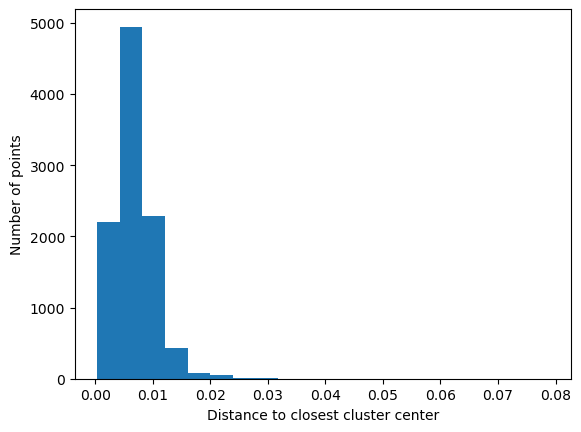

In [53]:
# Calculate the distance between each point and its cluster center
distance = kmeans.transform(X)

# Get the minimum distance for each point and its cluster index
min_distance = np.min(distance, axis=1)
min_distance_cluster = np.argmin(distance, axis=1)

# Plot a histogram of the minimum distance to a cluster center
plt.hist(min_distance, bins=20)
plt.xlabel('Distance to closest cluster center')
plt.ylabel('Number of points')
plt.show()

In [54]:
threshold = 0.015

# For each cluster, get the distance of each point from its cluster center and drop the points that are too far away from it (more than the threshold)
print(df_sample['cluster'])




16303534    19
10311866     9
17229606     6
4463430     12
10376436    14
            ..
14863760    14
15336225     3
13020498     6
13215998    18
4635301     19
Name: cluster, Length: 10000, dtype: int32


## Find the cluster with the most instances (the cluster with the biggest demand)

In [55]:
# Group the dataframe by 'cluster' and get the unique values of 'start_station_id' for each group
station_ids_by_cluster = df_sample.groupby('cluster')['start_station_id'].unique()

# Loop through each group and for each station ID, filter the dataframe to get all the instances of that station in the cluster and sum them together
cluster_instances = {}
for cluster, station_ids in station_ids_by_cluster.items():
    total_instances = 0
    for station_id in station_ids:
        station_instances = df_sample[(df_sample['cluster'] == cluster) & (df_sample['start_station_id'] == station_id)]
        total_instances += len(station_instances)
    cluster_instances[cluster] = total_instances

# Sort the dictionary by values in descending order
sorted_clusters = sorted(cluster_instances.items(), key=lambda x: x[1], reverse=True)

# Print the clusters in descending order by instances
# for cluster, instances in sorted_clusters:
#     print('Cluster', cluster, 'has', instances, 'instances')

print(f'Most important cluster: {sorted_clusters[0][0]}')
print(f'Number of instances: {sorted_clusters[0][1]}')

# Sum the number of instances for all clusters
print('------------------------------------------------------------------------------------------------------------------------')
print(f'Validating that the number of instances in all clusters (calculated) is equal to the total number of instances in the dataframe...')
total_instances = sum(cluster_instances.values())
print(f'Total number of instances: {total_instances}')
print(f'Percentage of instances in the most important cluster: {round(sorted_clusters[0][1] / total_instances * 100, 2)}%')
print(f'Number of all instances in the dataframe: {len(df)}')

Most important cluster: 18
Number of instances: 935
------------------------------------------------------------------------------------------------------------------------
Validating that the number of instances in all clusters (calculated) is equal to the total number of instances in the dataframe...
Total number of instances: 9999
Percentage of instances in the most important cluster: 9.35%
Number of all instances in the dataframe: 17548339


In [63]:
#Trasform startime and stoptimeinto datetime data
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 882 to 851
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               10000 non-null  int64  
 1   starttime                10000 non-null  object 
 2   stoptime                 10000 non-null  object 
 3   start_station_id         9999 non-null   float64
 4   start_station_latitude   10000 non-null  float64
 5   start_station_longitude  10000 non-null  float64
 6   end_station_id           9999 non-null   float64
 7   end_station_latitude     10000 non-null  float64
 8   end_station_longitude    10000 non-null  float64
 9   bikeid                   10000 non-null  int64  
 10  usertype                 10000 non-null  object 
 11  birth_year               10000 non-null  int64  
 12  gender                   10000 non-null  int64  
 13  cluster                  10000 non-null  int32  
dtypes: float64(6), int32(1), in

## Create time series of the duration of the trip

In [62]:
df_sample.tripduration

AttributeError: 'DataFrame' object has no attribute 'tripduration'

In [57]:
import matplotlib.pyplot as plt

# Set the 'stoptime' column as the index
df_sample.set_index('tripduration', inplace=True)

# Resample the data by day and count the number of events
resampled_data = df_sample.resample('M').size()

# Plot the time series
plt.figure(figsize=(12, 6))
resampled_data.plot(marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Analysis')
plt.show()


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'